In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.cluster import KMeans

with open('new.pkl', 'rb') as f:
    cluster_labels = pickle.load(f)
    
dataset = pd.read_csv('final_1102022.csv')
dataset['cluster_id'] = cluster_labels


dataset = dataset.loc[dataset['GM%'] >= -10]
dataset = dataset.loc[dataset['GM%'] <= 1]

In [2]:
dataset.shape

(1100264, 28)

In [3]:
## DROP WHERE # OF DATAPOINTS < 5 (cannot cluster at all)
cluster_sizes = dataset.groupby(['cluster_id']).cluster_id.size()
bad_clusters = cluster_sizes.where(lambda x: x < 5).dropna()
print("dropping clusters: ", bad_clusters.index)

dataset = dataset.loc[~dataset['cluster_id'].isin(bad_clusters.index)]

clusters = dataset.cluster_id.unique()
print("has clusters: ", clusters, " len = ", len(clusters))

dropping clusters:  Int64Index([3, 48, 51], dtype='int64', name='cluster_id')
has clusters:  [37 40 53 63 78 57 23 67 77 69 35 66 20 26 70 52 62 72 21 82 13 87 27 80
 25 61 81 32 46 68 74 17 29 38 28 33 16 45 42 10 19 76  2 39 65 22 41 79
 86 34 84 49 71 59  0 58 43 24 83 18  1 15 73 54 50 44 64  6 30 31 56 47
  7 55 75 12 11 36  9 60  8  5 14]  len =  83


In [4]:
#kmeans = [KMeans(n_clusters=5).fit(np.array(dataset.loc[dataset.cluster_id == cid]['GM%'].array).reshape(-1, 1)) for cid in cluster_labels]

kmeans_objs = [] # list of tuples - cluster id, corresponding KMeans obj
for cid in clusters:
    data = np.array(dataset.loc[dataset.cluster_id == cid]['GM%'].array).reshape(-1, 1)
    #print("training KMeans on {} datapoints for cluster {}".format(data.shape[0], cid))
    kmeans = KMeans(n_clusters=5).fit(data)
    kmeans_objs.append((cid, kmeans))

In [5]:
# dataset diff between max and min GM%
print("in entire dataset, gm% range: ", dataset['GM%'].max() - dataset['GM%'].min())

dgb = dataset.groupby(['cluster_id'])
gm_ranges = (dgb['GM%'].max() - dgb['GM%'].min())
print(gm_ranges)



in entire dataset, gm% range:  11.0
cluster_id
0     10.572816
1     10.967439
2     10.935484
5      2.352332
6     10.333333
        ...    
82     9.642857
83    10.671053
84    10.894737
86    10.720000
87    10.570928
Name: GM%, Length: 83, dtype: float64


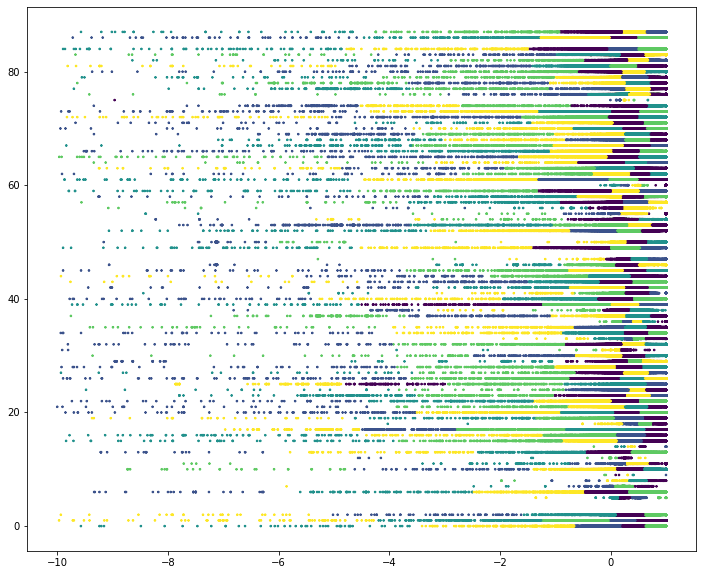

In [6]:
# assign price grades for each cluster centroid/labels
import matplotlib.pyplot as plt
for cid, kmeans in kmeans_objs:
    dataset.loc[dataset.cluster_id == cid, 'price_grade_cluster_ind'] = kmeans.labels_

dataset['price_grade_cluster_ind'] = dataset['price_grade_cluster_ind'].astype(int)


fig = plt.gcf()
fig.set_size_inches(12, 10)

i = 0
for cid in clusters:
    data = dataset.loc[dataset.cluster_id == cid]
    
    plt.scatter(data['GM%'], [cid]*data.shape[0], marker='x', s=3,c=data['price_grade_cluster_ind'])
#fig.savefig('test2png.png', dpi=200)


In [7]:
clusters_df = pd.DataFrame(clusters, columns=['cluster_id'])
clusters_df.set_index('cluster_id')

for cid, kmeans in kmeans_objs:
    label_center = sorted(zip(range(5), kmeans.cluster_centers_), key=lambda el: el[1], reverse=True)
    clusters_df.loc[clusters_df.cluster_id == cid, 'a_label'] = label_center[0][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'b_label'] = label_center[1][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'c_label'] = label_center[2][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'd_label'] = label_center[3][0]
    clusters_df.loc[clusters_df.cluster_id == cid, 'f_label'] = label_center[4][0]
    
clusters_df = clusters_df.astype({'a_label': int, 'b_label': int, 'c_label': int, 'd_label': int, 'f_label': int})

In [8]:
#assign 'price_grade' column to dataset

for cid in clusters:
    a_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['a_label'])
    b_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['b_label'])
    c_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['c_label'])
    d_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['d_label'])
    f_label_for_cluster = int(clusters_df.loc[clusters_df.cluster_id == cid]['f_label'])

    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == a_label_for_cluster), 'price_grade'] = 'A'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == b_label_for_cluster), 'price_grade'] = 'B'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == c_label_for_cluster), 'price_grade'] = 'C'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == d_label_for_cluster), 'price_grade'] = 'D'
    dataset.loc[(dataset.cluster_id == cid) & (dataset.price_grade_cluster_ind == f_label_for_cluster), 'price_grade'] = 'F'

In [9]:
price_grade_sizes = dataset[['cluster_id', 'price_grade']].groupby(['cluster_id', 'price_grade'], as_index=False).size()
a_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='A'][['cluster_id', 'size']].rename(columns={'size':'a_size'})
b_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='B'][['cluster_id', 'size']].rename(columns={'size':'b_size'})
c_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='C'][['cluster_id', 'size']].rename(columns={'size':'c_size'})
d_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='D'][['cluster_id', 'size']].rename(columns={'size':'d_size'})
f_price_grade_sizes = price_grade_sizes[price_grade_sizes.price_grade=='F'][['cluster_id', 'size']].rename(columns={'size':'f_size'})

clusters_df = clusters_df.merge(a_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(b_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(c_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(d_price_grade_sizes, on=['cluster_id'])
clusters_df = clusters_df.merge(f_price_grade_sizes, on=['cluster_id'])

In [10]:

cluster_sizes = dataset.groupby(['cluster_id'], as_index=False).cluster_id.size().rename(columns={'size': 'cluster_size'})
clusters_df = clusters_df.merge(cluster_sizes, on=['cluster_id'])

In [11]:
clusters_df['Adata%'] = 100.0*(clusters_df['a_size']/clusters_df['cluster_size']).round(4)
clusters_df['Bdata%'] = 100.0*(clusters_df['b_size']/clusters_df['cluster_size']).round(4)
clusters_df['Cdata%'] = 100.0*(clusters_df['c_size']/clusters_df['cluster_size']).round(4)
clusters_df['Ddata%'] = 100.0*(clusters_df['d_size']/clusters_df['cluster_size']).round(4)
clusters_df['Fdata%'] = 100.0*(clusters_df['f_size']/clusters_df['cluster_size']).round(4)
clusters_df = clusters_df.sort_values(by='cluster_id')


In [12]:
clusters_df

,cluster_id,a_label,b_label,c_label,d_label,f_label,a_size,b_size,c_size,d_size,f_size,cluster_size,Adata%,Bdata%,Cdata%,Ddata%,Fdata%
54,0,3,0,1,4,2,1369,4602,7732,373,48,14124,9.69,32.58,54.74,2.64,0.34
60,1,0,1,3,2,4,6230,12117,2319,253,64,20983,29.69,57.75,11.05,1.21,0.31
42,2,3,0,2,1,4,3597,10155,1330,62,26,15170,23.71,66.94,8.77,0.41,0.17
81,5,3,1,0,2,4,46,690,1175,1661,6,3578,1.29,19.28,32.84,46.42,0.17
67,6,3,0,4,2,1,5240,9804,541,115,34,15734,33.30,62.31,3.44,0.73,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,82,1,4,0,3,2,2561,6326,2968,224,36,12115,21.14,52.22,24.50,1.85,0.30
58,83,4,0,2,1,3,3012,9047,2379,107,27,14572,20.67,62.08,16.33,0.73,0.19
50,84,3,1,0,4,2,6012,12795,1964,201,73,21045,28.57,60.80,9.33,0.96,0.35
48,86,3,0,4,2,1,5353,11489,1976,188,49,19055,28.09,60.29,10.37,0.99,0.26


In [13]:

with pd.option_context('display.max_rows', None):
    display(clusters_df[['cluster_id', 'Adata%', 'Bdata%', 'Cdata%', 'Ddata%', 'Fdata%']])

,cluster_id,Adata%,Bdata%,Cdata%,Ddata%,Fdata%
54,0,9.69,32.58,54.74,2.64,0.34
60,1,29.69,57.75,11.05,1.21,0.31
42,2,23.71,66.94,8.77,0.41,0.17
81,5,1.29,19.28,32.84,46.42,0.17
67,6,33.30,62.31,3.44,0.73,0.22
72,7,7.63,59.44,32.19,0.65,0.09
80,8,37.32,43.15,14.29,4.08,1.17
78,9,11.11,22.22,22.22,22.22,22.22
39,10,29.70,59.49,10.12,0.48,0.21
76,11,38.40,16.13,43.25,2.09,0.13


In [14]:
gm_ranges = dataset.groupby(['cluster_id', 'price_grade'], as_index=False).agg({'GM%': ['min', 'max']})
gm_ranges.columns = ['cluster_id', 'price_grade', 'gm%min', 'gm%max']
clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'A'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Agm%min', 'gm%max': 'Agm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'B'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Bgm%min', 'gm%max': 'Bgm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'C'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Cgm%min', 'gm%max': 'Cgm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'D'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Dgm%min', 'gm%max': 'Dgm%max'})

clusters_df = clusters_df.merge(gm_ranges.loc[gm_ranges['price_grade'] == 'F'][['cluster_id', 'gm%min', 'gm%max']], on='cluster_id')
clusters_df = clusters_df.rename(columns={'gm%min': 'Fgm%min', 'gm%max': 'Fgm%max'})

In [29]:
clusters_df['total_pricing_width'] = clusters_df['Agm%max'] - clusters_df['Fgm%min']
clusters_df['Apricing_width%'] = (100.0*(clusters_df['Agm%max'] - clusters_df['Agm%min'])/clusters_df['total_pricing_width']).round(2)
clusters_df['Bpricing_width%'] = (100.0*(clusters_df['Bgm%max'] - clusters_df['Bgm%min'])/clusters_df['total_pricing_width']).round(2)
clusters_df['Cpricing_width%'] = (100.0*(clusters_df['Cgm%max'] - clusters_df['Cgm%min'])/clusters_df['total_pricing_width']).round(2)
clusters_df['Dpricing_width%'] = (100.0*(clusters_df['Dgm%max'] - clusters_df['Dgm%min'])/clusters_df['total_pricing_width']).round(2)
clusters_df['Fpricing_width%'] = (100.0*(clusters_df['Fgm%max'] - clusters_df['Fgm%min'])/clusters_df['total_pricing_width']).round(2)

In [30]:
display(clusters_df)

,cluster_id,a_label,b_label,c_label,d_label,f_label,a_size,b_size,c_size,d_size,...,Dgm%min,Dgm%max,Fgm%min,Fgm%max,total_pricing_width,Apricing_width%,Bpricing_width%,Cpricing_width%,Dpricing_width%,Fpricing_width%
0,0,3,0,1,4,2,1369,4602,7732,373,...,-3.407595,-0.656217,-9.572816,-3.635409,10.572816,3.54,4.01,7.99,26.02,56.16
1,1,0,1,3,2,4,6230,12117,2319,253,...,-4.191941,-1.252427,-9.967439,-4.286522,10.967439,4.76,4.42,11.27,26.80,51.80
2,2,3,0,2,1,4,3597,10155,1330,62,...,-5.017172,-1.618507,-9.935484,-5.456250,10.935484,3.49,4.74,15.22,31.08,40.96
3,5,3,1,0,2,4,46,690,1175,1661,...,-0.270073,0.152928,-1.352332,-1.166667,2.352332,5.60,10.96,8.26,17.98,7.89
4,6,3,0,4,2,1,5240,9804,541,115,...,-5.608974,-2.500000,-9.333333,-6.277992,10.333333,6.68,7.57,19.26,30.09,29.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,82,1,4,0,3,2,2561,6326,2968,224,...,-2.888889,-0.486757,-8.642857,-3.124360,9.642857,3.26,3.94,8.13,24.91,57.23
79,83,4,0,2,1,3,3012,9047,2379,107,...,-4.200000,-0.996833,-9.671053,-4.327600,10.671053,3.58,4.20,10.72,30.02,50.07
80,84,3,1,0,4,2,6012,12795,1964,201,...,-4.769811,-1.486389,-9.894737,-4.866667,10.894737,4.69,4.91,13.02,30.14,46.15
81,86,3,0,4,2,1,5353,11489,1976,188,...,-4.455882,-1.280992,-9.720000,-4.589041,10.720000,4.82,4.60,11.67,29.62,47.86
